In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
from tensorflow import keras
from toai.imports import *

from data import DataContainer
from image import *
from image_learner import ImageLearner
from transformations import ImageParser, ImageCropTransformation, ImageRandomCropTransformation, ImageLRFlpTransformation, ImageTransformation, ImageUDFlpTransformation

from sklearn.metrics import classification_report, confusion_matrix, f1_score
import sklearn
from train_cycle import TrainCycle

In [4]:
tf.debugging.set_log_device_placement(False)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            print(gpu)
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


In [5]:
DATA_DIR = Path('data')
TEMP_DIR = Path('temp')
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [32]:
df = pd.read_csv('train.csv', low_memory=False)
df['date_captured'] = pd.to_datetime(
    df['date_captured'], 
    infer_datetime_format=True,
    errors='coerce',
    yearfirst=True
)
labels = pd.read_csv('labels.csv')

In [33]:
df = pd.merge(df, labels, left_on='category_id', right_on='id')
df.drop(columns='id_y', inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196299 entries, 0 to 196298
Data columns (total 12 columns):
category_id       196299 non-null int64
date_captured     196298 non-null datetime64[ns]
file_name         196299 non-null object
frame_num         196299 non-null int64
id_x              196299 non-null object
location          196299 non-null int64
rights_holder     196299 non-null object
seq_id            196299 non-null object
seq_num_frames    196299 non-null int64
width             196299 non-null int64
height            196299 non-null int64
name              196299 non-null object
dtypes: datetime64[ns](1), int64(6), object(5)
memory usage: 19.5+ MB


In [9]:
df.head().T

,0,1,2,3,4
category_id,19,19,19,19,19
date_captured,2011-05-13 23:43:18,2012-03-17 03:48:44,2012-05-07 23:17:19,2010-06-04 01:32:16,2010-10-07 20:14:32
file_name,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,588a679f-23d2-11e8-a6a3-ec086b02610b.jpg,5883e97b-23d2-11e8-a6a3-ec086b02610b.jpg,58d47cf1-23d2-11e8-a6a3-ec086b02610b.jpg,58d15f82-23d2-11e8-a6a3-ec086b02610b.jpg
frame_num,1,2,1,4,2
id_x,5998cfa4-23d2-11e8-a6a3-ec086b02610b,588a679f-23d2-11e8-a6a3-ec086b02610b,5883e97b-23d2-11e8-a6a3-ec086b02610b,58d47cf1-23d2-11e8-a6a3-ec086b02610b,58d15f82-23d2-11e8-a6a3-ec086b02610b
location,33,115,78,100,100
rights_holder,Justin Brown,Justin Brown,Justin Brown,Justin Brown,Justin Brown
seq_id,6f084ccc-5567-11e8-bc84-dca9047ef277,6f12067d-5567-11e8-b3c0-dca9047ef277,6f1c553d-5567-11e8-9f6c-dca9047ef277,6f1d1eeb-5567-11e8-92ef-dca9047ef277,6f1d875c-5567-11e8-af6d-dca9047ef277
seq_num_frames,3,3,3,5,3
width,1024,1024,1024,1024,1024


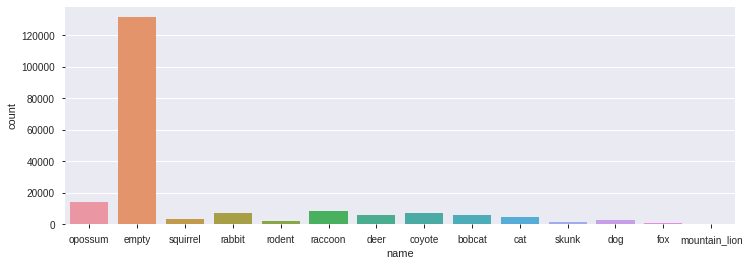

In [10]:
plt.figure(figsize=(12,4))
sns.countplot(x='name', data=df);

In [11]:
df['name'].value_counts(normalize=True)

empty            0.669677
opossum          0.071860
raccoon          0.043928
coyote           0.036725
rabbit           0.035344
deer             0.031085
bobcat           0.030438
cat              0.024244
squirrel         0.017310
dog              0.015461
rodent           0.011258
skunk            0.006933
fox              0.005568
mountain_lion    0.000168
Name: name, dtype: float64

In [34]:
df['path'] = df['file_name'].apply(lambda fn : str(DATA_DIR/'train'/fn))

In [13]:
df.head(1)

,category_id,date_captured,file_name,frame_num,id_x,location,rights_holder,seq_id,seq_num_frames,width,height,name,path
0,19,2011-05-13 23:43:18,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,1,5998cfa4-23d2-11e8-a6a3-ec086b02610b,33,Justin Brown,6f084ccc-5567-11e8-bc84-dca9047ef277,3,1024,747,opossum,data/train/5998cfa4-23d2-11e8-a6a3-ec086b02610...


In [14]:
test_df = pd.read_csv('test.csv', low_memory=False)
test_df['path'] = test_df['file_name'].apply(lambda fn : str(DATA_DIR/'test'/fn))

In [15]:
test_df.head()

,date_captured,file_name,frame_num,id,location,rights_holder,seq_id,seq_num_frames,width,height,path
0,2016-01-03 11:30:56,bce932f6-2bf6-11e9-bcad-06f10d5896c4.jpg,1,bce932f6-2bf6-11e9-bcad-06f10d5896c4,37,Idaho Department of Fish and Game,6e9ac61c-2e32-11e9-90ef-dca9047ef277,5,1024,726,data/test/bce932f6-2bf6-11e9-bcad-06f10d5896c4...
1,2016-01-03 11:30:57,bce932f7-2bf6-11e9-bcad-06f10d5896c4.jpg,2,bce932f7-2bf6-11e9-bcad-06f10d5896c4,37,Idaho Department of Fish and Game,6e9ac61c-2e32-11e9-90ef-dca9047ef277,5,1024,726,data/test/bce932f7-2bf6-11e9-bcad-06f10d5896c4...
2,2016-01-03 11:30:58,bce932f8-2bf6-11e9-bcad-06f10d5896c4.jpg,3,bce932f8-2bf6-11e9-bcad-06f10d5896c4,37,Idaho Department of Fish and Game,6e9ac61c-2e32-11e9-90ef-dca9047ef277,5,1024,726,data/test/bce932f8-2bf6-11e9-bcad-06f10d5896c4...
3,2016-01-03 11:30:59,bce932f9-2bf6-11e9-bcad-06f10d5896c4.jpg,4,bce932f9-2bf6-11e9-bcad-06f10d5896c4,37,Idaho Department of Fish and Game,6e9ac61c-2e32-11e9-90ef-dca9047ef277,5,1024,726,data/test/bce932f9-2bf6-11e9-bcad-06f10d5896c4...
4,2016-01-03 11:31:00,bce932fa-2bf6-11e9-bcad-06f10d5896c4.jpg,5,bce932fa-2bf6-11e9-bcad-06f10d5896c4,37,Idaho Department of Fish and Game,6e9ac61c-2e32-11e9-90ef-dca9047ef277,5,1024,726,data/test/bce932fa-2bf6-11e9-bcad-06f10d5896c4...


In [16]:
def create_class_weight_map(df: pd.DataFrame, label_map: Dict[str, float], class_name: str):
    classes = np.unique(df[class_name])
    weights = sklearn.utils.class_weight.compute_class_weight('balanced', classes, df[class_name])
    
    return { label_map[key]: value for key, value in zip(classes, weights) }

In [20]:
# df = df.sample(frac=0.3, random_state=42)

In [35]:
train_data, validation_data = train_test_split(df, test_size=0.4)

In [36]:
validation_data, test_data = train_test_split(validation_data, test_size=0.5)

In [37]:
[data.shape for data in (train_data, validation_data, test_data)]

[(117779, 13), (39260, 13), (39260, 13)]

In [24]:
IMG_DIMS = (100, 100, 3)

In [25]:
class ImageHueTransformation(ImageTransformation):

    def __init__(self, hue: float = 0.2, probability: float = 1.0):
        self.hue = hue
        self.probability = probability

    def transform(self, image: tf.Tensor) -> tf.Tensor:
        return tf.cond(
            pred=tf.random.uniform([], 0, 1) < self.probability,
            true_fn=lambda: tf.image.random_hue(image, self.hue, seed=None),
            false_fn=lambda: image
        )

In [38]:
base_config = ImageDatasetConfig(
    img_dims=IMG_DIMS,
    batch_size=32,
    preprocess_pipeline=[
        ImageParser(),
        ImageCropTransformation(IMG_DIMS, crop_adjustment=1.5),
    ],
)

train_dataset = ImageDataset(base_config.copy(
        preprocess_pipeline=[
            ImageLRFlpTransformation(),
            ImageHueTransformation()
        ],
        shuffle=True,
    )).build_from_df(train_data, 'path', 'category_id')

data_container = DataContainer(
    train=train_dataset,
    validation=ImageDataset(base_config.copy(
        preprocess_pipeline = [
            ImageLRFlpTransformation(),
        ],
    )).with_label_map(train_dataset.label_map).build_from_df(validation_data, 'path', 'category_id'),
    test=ImageDataset(base_config.copy(
        preprocess_pipeline=[],
    )).with_label_map(train_dataset.label_map).build_from_df(test_data, 'path', 'category_id'),
)

In [27]:
class_weight = create_class_weight_map(train_data, train_dataset.label_map, 'category_id')

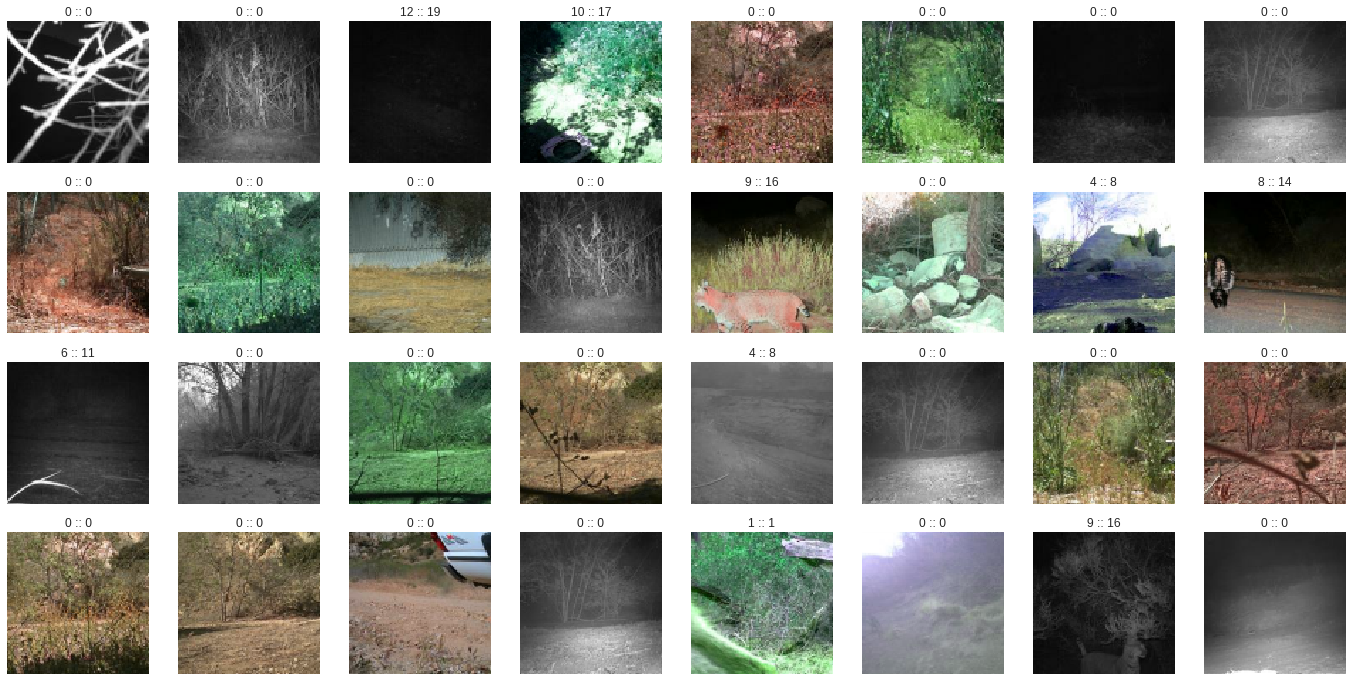

In [28]:
data_container.train.show()

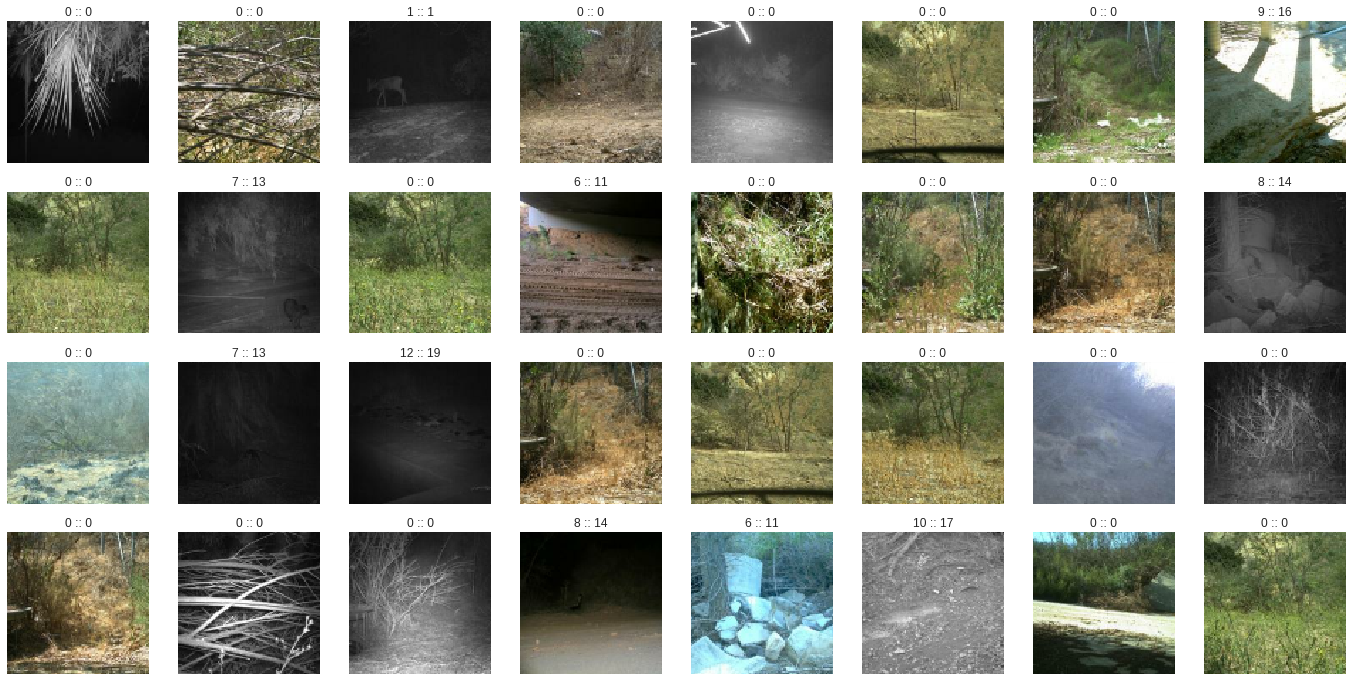

In [28]:
data_container.test.show()

In [29]:
train_cycle = TrainCycle(
    epochs=5,
    batch_size=base_config.batch_size,
    train_set_size=data_container.train.length,
    lr = (1e-3, 1e-5),
)

In [30]:
learner = ImageLearner(
    model_path=Path('xception-basic'),
    data=data_container,
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    activation=keras.activations.softmax,
    dropout=0.1,
)

In [31]:
learner.auto_train(
    easing_epochs=3,
    epochs=5,
    optimizer=keras.optimizers.Adam,
    lr=3e-4,
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=[keras.metrics.sparse_categorical_accuracy],
    callbacks=[train_cycle],
)

Freezing all except last model layers
Training frozen model
Train for 1105 steps, validate for 369 steps
Epoch 1/3
1105/1105 [==============================] - 38s 34ms/step - loss: 1.2240 - sparse_categorical_accuracy: 0.7110 - val_loss: 1.3679 - val_sparse_categorical_accuracy: 0.6851
Epoch 2/3
1105/1105 [==============================] - 34s 31ms/step - loss: 0.9524 - sparse_categorical_accuracy: 0.7482 - val_loss: 1.3025 - val_sparse_categorical_accuracy: 0.6861
Epoch 3/3
1105/1105 [==============================] - 34s 31ms/step - loss: 0.8735 - sparse_categorical_accuracy: 0.7592 - val_loss: 1.2700 - val_sparse_categorical_accuracy: 0.6842
Loading weights only from xception-basic/weights.h5
Model loaded successfully
Unfreezing all layers
Finished training frozen model
Starting model training
Train for 1105 steps, validate for 369 steps
Epoch 1/5
1105/1105 [==============================] - 106s 96ms/step - loss: 0.8454 - sparse_categorical_accuracy: 0.7535 - val_loss: 0.6773 - va

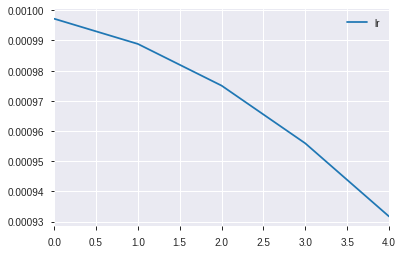

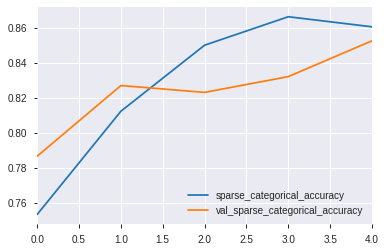

In [50]:
learner.show_history(contains='lr') 
learner.show_history(contains='acc')

In [32]:
predictions = learner.predict_dataset(mode='test', verbose=1).argmax(axis=1)

369/369 [==============================] - 8s 21ms/step


In [43]:
y_true = test_data['category_id'].apply(lambda n : data_container.train.label_map[n])
targets = {key: value for key, value in enumerate(dict(labels.values))}
target_names = [targets[key] for key in data_container.train.label_map.keys()]

In [84]:
print(classification_report(y_true, predictions, target_names=target_names))

               precision    recall  f1-score   support

        empty       0.86      0.95      0.90      7857
         deer       0.59      0.66      0.63       389
     squirrel       0.66      0.11      0.19       186
       rodent       0.47      0.06      0.11       147
       rabbit       0.28      0.14      0.19       409
          fox       0.12      0.17      0.14        66
       coyote       0.53      0.29      0.38       447
      raccoon       0.43      0.67      0.52       541
        skunk       0.50      0.11      0.18        75
       bobcat       0.27      0.22      0.25       361
          cat       0.31      0.06      0.10       280
          dog       0.27      0.42      0.33       185
      opossum       0.64      0.43      0.51       832
mountain_lion       0.00      0.00      0.00         3

     accuracy                           0.75     11778
    macro avg       0.42      0.31      0.32     11778
 weighted avg       0.73      0.75      0.73     11778



/home/martynas/ml/.venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
learner_weighted = ImageLearner(
    model_path=Path('xception-weighted'),
    data=data_container,
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    activation=keras.activations.softmax,
    dropout=0.2,
)

Existing model data path exists
Loading architecture and weights from xception-weighted
Model loaded successfully


In [40]:
learner_weighted.auto_train(
    easing_epochs=0,
    epochs=10,
    optimizer=keras.optimizers.Adam,
    lr=3e-4,
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=[keras.metrics.sparse_categorical_accuracy],
    class_weight=class_weight
)

Starting model training
Train for 3681 steps, validate for 1227 steps
Epoch 1/10
3681/3681 [==============================] - 334s 91ms/step - loss: 0.3691 - sparse_categorical_accuracy: 0.8857 - val_loss: 0.2864 - val_sparse_categorical_accuracy: 0.9110
Epoch 2/10
3681/3681 [==============================] - 331s 90ms/step - loss: 0.2507 - sparse_categorical_accuracy: 0.9202 - val_loss: 3.9278 - val_sparse_categorical_accuracy: 0.7879
Epoch 3/10
3681/3681 [==============================] - 331s 90ms/step - loss: 0.2047 - sparse_categorical_accuracy: 0.9334 - val_loss: 0.3201 - val_sparse_categorical_accuracy: 0.9176
Epoch 4/10
3681/3681 [==============================] - 332s 90ms/step - loss: 0.1719 - sparse_categorical_accuracy: 0.9445 - val_loss: 0.2344 - val_sparse_categorical_accuracy: 0.9291
Epoch 5/10
3681/3681 [==============================] - 331s 90ms/step - loss: 0.1462 - sparse_categorical_accuracy: 0.9524 - val_loss: 0.2381 - val_sparse_categorical_accuracy: 0.9309
Epoch

In [41]:
predictions = learner_weighted.predict_dataset(mode='test', verbose=1).argmax(axis=1)

1227/1227 [==============================] - 25s 20ms/step


In [44]:
print(classification_report(y_true, predictions, target_names=target_names))

               precision    recall  f1-score   support

        empty       0.84      0.95      0.89     26257
         deer       0.81      0.67      0.73      1179
     squirrel       0.43      0.17      0.24       666
       rodent       0.52      0.05      0.10       458
       rabbit       0.37      0.16      0.23      1334
          fox       0.53      0.31      0.39       208
       coyote       0.49      0.51      0.50      1456
      raccoon       0.60      0.55      0.58      1727
        skunk       0.29      0.53      0.37       270
       bobcat       0.57      0.36      0.44      1222
          cat       0.46      0.25      0.32       989
          dog       0.68      0.32      0.44       624
      opossum       0.67      0.55      0.60      2867
mountain_lion       0.00      0.00      0.00         3

     accuracy                           0.78     39260
    macro avg       0.52      0.38      0.42     39260
 weighted avg       0.75      0.78      0.75     39260



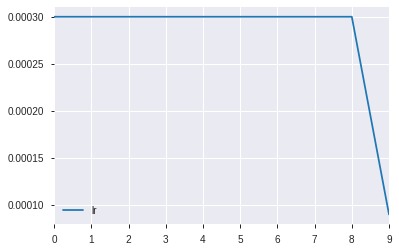

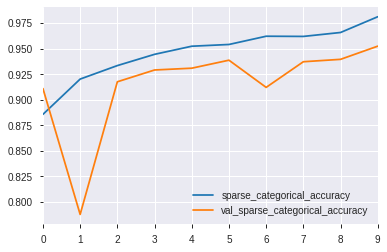

In [45]:
learner_weighted.show_history('lr')
learner_weighted.show_history('acc')